In [1]:
import json
import math
from concurrent.futures import ThreadPoolExecutor
from subprocess import check_call, check_output
from tempfile import TemporaryDirectory

import geopandas as gpd
from contextily import add_basemap
from shapely import intersects
from shapely.geometry import box
import rasterio as rio


In [22]:
# Data to load parameter from GEE catalog
palsar_id = "projects/earthengine-public/assets/JAXA/ALOS/PALSAR-2/Level2_2/ScanSAR"
palsar_bands = ["HH", "HV"]
mask_band = "MSK"

# Date or period
years = [2015, 2020, 2025]

In [2]:
# Indonesia administration data level 1
admin_1 = (
    "https://storage.googleapis.com/gee-ramiqcom-bucket/admin/indonesia_adm_level_1.fgb"
)
admin_df = gpd.read_file(admin_1, bbox=(102.5, -1.75, 103, -1.5))
admin_df

,WADMPR,geometry
0,Jambi,"MULTIPOLYGON Z (((101.2744 -2.20868 0, 101.275..."


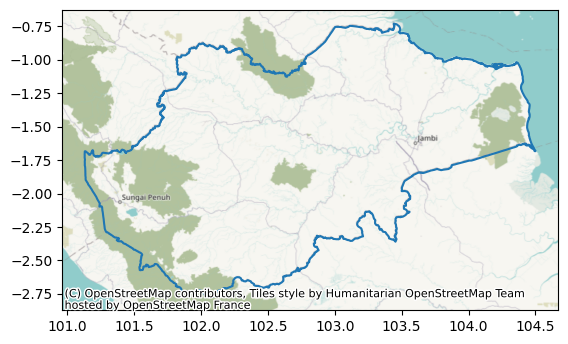

In [3]:
# Plot the adm data
ax = admin_df.boundary.plot()
add_basemap(ax, crs="EPSG:4326")

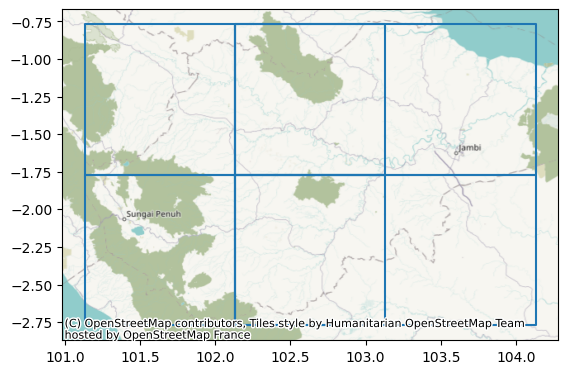

In [ ]:
# Create grid with 1 x 1 degree covering the area of interest
bounds = tuple(admin_df.total_bounds)
min_x, min_y, max_x, max_y = bounds
interval = 1
count_x = math.ceil(abs(min_x - max_x) / interval)
count_y = math.ceil(abs(min_y - max_y) / interval)
grids = []
for x in range(count_x):
    for y in range(count_y):
        min_x_grid = min_x + (x * interval)
        max_x_grid = min_x + interval
        min_y_grid = min_y + (y * interval)
        max_y_grid = min_y + interval
        polygon = box(min_x_grid, min_y_grid, max_x_grid, max_y_grid)
        if intersects(polygon, admin_df.union_all()):
            grids.append(
                dict(
                    min_x=min_x_grid,
                    min_y=min_y_grid,
                    max_x=max_x_grid,
                    max_y=max_x_grid,
                    name=f"{y:02d}Y_{x:02d}X",
                    geometry=polygon,
                )
            )
grids = gpd.GeoDataFrame(grids, crs="EPSG:4326")

# Plot geometry
ax = grids.boundary.plot()
add_basemap(ax, crs="EPSG:4326")

In [18]:
# Imagery shape
resolution = 30
width = int(111_000 / resolution)
height = int(111_000 / resolution)
height, width

(3700, 3700)

In [ ]:
# Function to get GEE data as geotiff
def to_geotiff(
    data_path: str,
    bounds: list[float] | tuple[float, float, float, float] | None = None,
    bands: list[str] | None = None,
    resampling: str = "nearest",
    dtype: str | None = None,
    nodata: str | float | int | None = None,
):
    temp_folder = TemporaryDirectory(delete=False)
    tif = f"{temp_folder.name}/image.tif"
    check_call(
        f"""gdalwarp \
            {f"-ot {dtype}" if dtype is not None else ""} \
            {f"-dstnodata {nodata}" if nodata is not None else ""} \
            -r {resampling} \
            -oo PIXEL_ENCODING=GEO_TIFF \
            {f"-oo BANDS={' '.join(bands)}" if bands is not None else ""} \
            -of COG \
            -co COMPRESS=ZSTD \
            -t_srs EPSG:4326 \
            {f"-te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]}" if bounds is not None else ""} \
            {data_path} \
            {tif}
      """
    )
    return tif


# Function to mask image
def mask_image(
    A: str,
    B: str,
    calc: str,
    dtype: str | None = None,
    nodata: str | float | int | None = 0,
):
    temp_folder = TemporaryDirectory(delete=False)
    mask = f"{temp_folder.name}/mask.tif"
    check_call(
        f"""gdal_calc \
            -A {A} \
            -B {B} \
            --calc="{calc}" \
            --outfile={mask} \
            --NoDataValue={nodata} \
            {f"--type={dtype}" if dtype is not None else ""}
        """,
        shell=True,
    )
    return mask


def median_composite(
    paths: list[str], dtype: str = "UInt16", nodata: str | int | float | None = 0
):
    temp_folder = TemporaryDirectory(delete=False)
    median = f"{temp_folder.name}/median.tif"
    check_call(
        f"""gdal_calc \
            -A {" ".join(paths)} \
            --calc="nanmean(A, axis=0)" \
            --outfile={median} \
            {f"--NoDataValue={nodata}" if nodata is not None else ""} \
            {f"--type={dtype}" if dtype is not None else ""}
        """,
        shell=True,
    )
    return median


# Function to load palsar based on the geometry and dates
def get_palsar(feat, year):
    # Get the bounds to filter the data
    bounds = tuple(feat.total_bounds)
    min_x, min_y, max_x, max_y = bounds

    # Define the date range
    start = f"{year}-05-01"
    end = f"{year}-08-31"

    # Filter the data with GDAL
    features = json.loads(
        check_output(
            f"""ogrinfo \
                -features \
                -json \
                -spat {min_x} {min_y} {max_x} {max_y} \
                -where "startTime >= '{start.replace("-", "/")} 00:00:00' AND endTime <= '{end.replace("-", "/")} 23:59:59'" \
                "EEDA:{palsar_id}"
            """,
            shell=True,
            text=True,
        )
    )["layers"][0]["features"]

    def process_palsar(feat):
        path = feat["properties"]["gdal_dataset"]
        mask = to_geotiff(data_path=path, bounds=bounds, bands=["MSK"])

        # Get the image first
        image_palsar = [
            to_geotiff(
                data_path=path,
                bounds=bounds,
                bands=[band],
                nodata=0,
                dtype="UInt16",
                resampling="lanczos",
            )
            for band in palsar_bands
        ]

        # Masked it
        masked_palsar = [
            mask_image(
                A=image,
                B=mask,
                calc="A * ((B & (5 << 1)) == 0) * ((B & (5 << 2)) == 0)",
                dtype="UInt16",
                nodata=0,
            )
            for image in image_palsar
        ]

        # Convert to float
        float_again = [
            to_geotiff(
                data_path=image,
                nodata="NaN",
                dtype="Float32",
                resampling="lanczos",
            )
            for image in masked_palsar
        ]

        return float_again

    with ThreadPoolExecutor(16) as executor:
        jobs = [executor.submit(process_palsar, feat) for feat in features]
        result = [job.result() for job in jobs]

    with ThreadPoolExecutor(2) as executor:
        jobs = [
            executor.submit(median_composite, [image[index] for image in result])
            for index in range(len(palsar_bands))
        ]
        medians = [job.result() for job in jobs]

    stacks = []
